# Problem 1

## Gillespie's Algorithm

### Imports and Helper Functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import copy
from scipy.integrate import solve_ivp
import seaborn as sns

def standardize_timesteps(data: list[list[float]], data_rate: float, max_t: int) -> np.ndarray:
    t_list = np.array(data[0])
    new_t_list = np.linspace(0, max_t, data_rate * max_t)
    result = np.zeros((len(data), len(new_t_list)))
    result[0] = new_t_list
    for i in range(1, len(data)):
        result[i] = np.interp(new_t_list, t_list, data[i])

    return result

### Classes

In [2]:
class Population:
    def __init__(self, initial_X, initial_Y, initial_Z):
        self.X = initial_X
        self.Y = initial_Y
        self.Z = initial_Z

    def __str__(self):
        return f"X = {self.X}, Y = {self.Y}, Z = {self.Z}"

    def N(self):
        return self.X + self.Y + self.Z
    
    def tuple(self):
        return (self.X, self.Y, self.Z)

class Gillespie_Parameters:
    def __init__(self, population_size, initial_infected, beta, gamma, mu, epsilon=0):
        self.population = Population(population_size - initial_infected, initial_infected, 0)
        self.beta = beta
        self.gamma = gamma
        self.mu = mu
        self.epsilon = epsilon
        self.r0 = beta / (gamma + mu)

    def __str__(self):
        return f"r0 = {self.r0:.2f}, beta = {self.beta:.2f}, gamma = {self.gamma:.2f}, mu = {self.mu:.2f}, epsilon = {self.epsilon:.5f}, N = {self.population.N()}"

class Event:
    def __init__(self, name, rate_function, result_function):
        self.name = name
        self.rate_function = rate_function
        self.result_function = result_function

    def get_rate(self, params: Gillespie_Parameters):
        return self.rate_function(params)
    
    def execute_result(self, population: Population):
        return self.result_function(population)

### Define the events

In [3]:
def _birth_rate(params: Gillespie_Parameters):
    return params.mu * params.population.N()
def _birth_result(pop: Population) -> Population:
    pop.X += 1
BirthEvent = Event('birth', _birth_rate, _birth_result)

def _transmission_rate(params: Gillespie_Parameters):
    return params.beta * params.population.X * params.population.Y / params.population.N()
def _transmission_result(pop: Population) -> Population:
    pop.X -= 1
    pop.Y += 1
TransmissionEvent = Event('transmission', _transmission_rate, _transmission_result)

def _recovery_rate(params: Gillespie_Parameters):
    return params.gamma * params.population.Y
def _recovery_result(pop: Population) -> Population:
    pop.Y -= 1
    pop.Z += 1
RecoveryEvent = Event('recovery', _recovery_rate, _recovery_result)

def _death_x_rate(params: Gillespie_Parameters):
    return params.mu * params.population.X
def _death_x_result(pop: Population) -> Population:
    pop.X -= 1
DeathXEvent = Event('death_x', _death_x_rate, _death_x_result)

def _death_y_rate(params: Gillespie_Parameters):
    return params.mu * params.population.Y
def _death_y_result(pop: Population) -> Population:
    pop.Y -= 1
DeathYEvent = Event('death_y', _death_y_rate, _death_y_result)

def _death_z_rate(params: Gillespie_Parameters):
    return params.mu * params.population.Z
def _death_z_result(pop: Population) -> Population:
    pop.Z -= 1
DeathZEvent = Event('death_z', _death_z_rate, _death_z_result)

def _import_rate(params: Gillespie_Parameters):
    return params.epsilon
def _import_result(pop: Population) -> Population:
    pop.Y += 1
    pop.X -= 1
ImportEvent = Event('import', _import_rate, _import_result)

events = [BirthEvent, TransmissionEvent, RecoveryEvent, DeathXEvent, DeathYEvent, DeathZEvent]

### Prepare Gillespie Simulation

In [4]:
class Result:
    def __init__(self, results: np.ndarray):
        self.t = results[0]
        self.X = results[1]
        self.Y = results[2]
        self.Z = results[3]

    def s_i_covariance(self):
        return np.cov(self.X, self.Y)[0][1]

class Results:
    def __init__(self, t: np.ndarray):
        self.t = t
        self.Xs = np.ndarray((0, len(t)))
        self.Ys = np.ndarray((0, len(t)))
        self.Zs = np.ndarray((0, len(t)))
    
    def add_result(self, result: Result):
        if result.t[0] != self.t[0]:
            raise ValueError('All results must have the same timesteps')
        self.Xs = np.vstack((self.Xs, result.X))
        self.Ys = np.vstack((self.Ys, result.Y))
        self.Zs = np.vstack((self.Zs, result.Z))

    def mean_result(self):
        return Result(np.array([self.t, np.mean(self.Xs, axis=0), np.mean(self.Ys, axis=0), np.mean(self.Zs, axis=0)]))

    def mean_and_std_infected(self):
        return np.mean(self.Ys, axis=0), np.std(self.Ys, axis=0)
    
    def mean_and_minmax_infected(self):
        minmax = np.zeros((2, len(self.t)))
        minmax[0] = np.min(self.Ys, axis=0)
        minmax[1] = np.max(self.Ys, axis=0)
        return np.mean(self.Ys, axis=0), minmax

def get_rates(events: list[Event], params: Gillespie_Parameters):
    return [e.get_rate(params) for e in events]

def get_delta_ts(rates: list[float]):
    rands = np.random.rand(len(rates))
    while 0 in rands: # avoid zeros
        rands = np.random.rand(len(rates))
    delta_ts = np.full(len(rates), np.inf)
    for i, r in enumerate(rates):
        if r == 0:
            continue
        delta_ts[i] = (-1 / r) * np.log(rands[i])
    return delta_ts


def gillespie(params: Gillespie_Parameters, events: list[Event], t_max) -> list[list[float]]:
    t = 0.0
    params
    results = [[], [], [], []] # t, X, Y, Z
    pop = copy.deepcopy(params.population)
    extinct = False
    while t < t_max and params.population.N() > 0:
        rates = get_rates(events, params)
        delta_ts = get_delta_ts(rates)
        event_index = np.argmin(delta_ts)
        t += delta_ts[event_index]
        events[event_index].execute_result(params.population)
        if not extinct and params.population.Y == 0:
            print(f'Extinction at t={t:.2f}')
            extinct = True
        if extinct and params.population.Y >= 2:
            print(f'Import at t={t:.2f}')
            extinct = False
        results[0].append(t)
        results[1].append(params.population.X)
        results[2].append(params.population.Y)
        results[3].append(params.population.Z)
        # print(f'{events[event_index].name} at t={t}, N={params.population.N()}')
    params.population = pop
    return results

class Experiment:
    def __init__(self, params: Gillespie_Parameters, events: list[Event], simulation_length: int, data_rate=1, min_iterations=5, max_iterations=1, target_rse=0.05, store_raw=False):
        self.params = params
        self.events = events
        self.simulation_length = simulation_length
        self.data_rate = data_rate
        self.min_iterations = min_iterations
        self.max_iterations = max_iterations
        self.store_raw = store_raw
        self.target_rse = target_rse
        self.standard_t = np.linspace(0, self.simulation_length, self.simulation_length * self.data_rate)

    def run(self):
        print(f'Running experiment: {str(self.params)}')
        self.raw_results = [] if self.store_raw else None
        self.results = Results(self.standard_t)
        self.extinction_counts = np.zeros(self.max_iterations)
        self.rses = np.full(self.max_iterations, np.nan, dtype=float)
        for i in range(self.max_iterations):
            start = time.perf_counter()
            raw_result = gillespie(self.params, self.events, self.simulation_length)
            if self.store_raw:
                self.raw_results.append(raw_result)
            extinct = False
            for j in range(len(raw_result[2])):
                if not extinct and raw_result[2][j] == 0:
                    extinct = True
                    self.extinction_counts[i] += 1
                if extinct and raw_result[2][j] >= 2:
                    extinct = False
            self.results.add_result(Result(standardize_timesteps(raw_result, self.data_rate, self.simulation_length)))
            rse = self.avg_rse_infected()
            self.rses[i] = rse
            end = time.perf_counter()
            print(f'Ran iteration {i+1} in {(end - start):.2f} seconds, rse={rse:.3f}')
            if i+1 >= self.min_iterations and rse < self.target_rse:
                break
        return self.results
    
    def integrate_deterministic_sir(self, deterministic_sir_function):
        return solve_ivp(
            deterministic_sir_function,
            (0, self.simulation_length),
            self.params.population.tuple(),
            t_eval=np.linspace(0, self.simulation_length, self.simulation_length * self.data_rate),
            args=(self.params.beta, self.params.gamma, self.params.mu))
    
    def avg_rse_infected(self):
        if len(self.results.Ys) <= 1:
            return 0.0
        mean, std = self.results.mean_and_std_infected()
        stderr = std / np.sqrt(len(self.results.Ys))
        nz_mean = mean != 0
        return np.mean(stderr[nz_mean] / mean[nz_mean])

        
  
class Experiments:
    def __init__(self, experiments: list[Experiment]):
        self.experiments = experiments

    def run(self):
        for e in self.experiments:
            e.run()

### Run Gillespie

Running experiment: r0 = 4.55, beta = 0.50, gamma = 0.10, mu = 0.01, epsilon = 0.00000, N = 5000.0
Ran iteration 1 in 0.79 seconds, rse=0.000


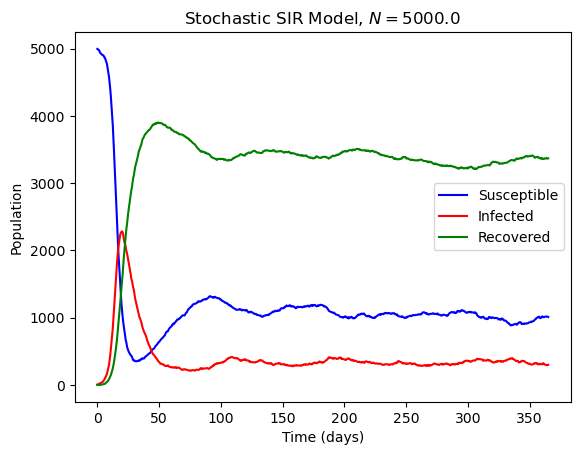

In [5]:
population_size = 5e3
initial_infected = 5
sim_length = 365
data_rate = 2
beta = 0.5
gamma = 0.1
mu = 1/100

experiment1 = Experiment(Gillespie_Parameters(population_size=population_size, initial_infected=initial_infected, beta=beta, gamma=gamma, mu=mu), events=events, simulation_length=sim_length, data_rate=data_rate)

r0 = beta / (gamma + mu)

res = experiment1.run().mean_result()

plt.plot(res.t, res.X, 'b', label='Susceptible')
plt.plot(res.t, res.Y, 'r', label='Infected')
plt.plot(res.t, res.Z, 'g', label='Recovered')
plt.legend(loc='right')
plt.xlabel('Time (days)')
plt.ylabel('Population')
plt.title(f'Stochastic SIR Model, $N={population_size}$')
plt.show()

## Compare to deterministic model

Running experiment: r0 = 4.55, beta = 0.50, gamma = 0.10, mu = 0.01, epsilon = 0.00000, N = 1000.0
Ran iteration 1 in 0.14 seconds, rse=0.000
Running experiment: r0 = 4.55, beta = 0.50, gamma = 0.10, mu = 0.01, epsilon = 0.00000, N = 10000.0
Ran iteration 1 in 1.38 seconds, rse=0.000
Running experiment: r0 = 4.55, beta = 0.50, gamma = 0.10, mu = 0.01, epsilon = 0.00000, N = 100000.0
Ran iteration 1 in 12.96 seconds, rse=0.000
Running experiment: r0 = 4.55, beta = 0.50, gamma = 0.10, mu = 0.01, epsilon = 0.00000, N = 1000000.0
Ran iteration 1 in 125.66 seconds, rse=0.000


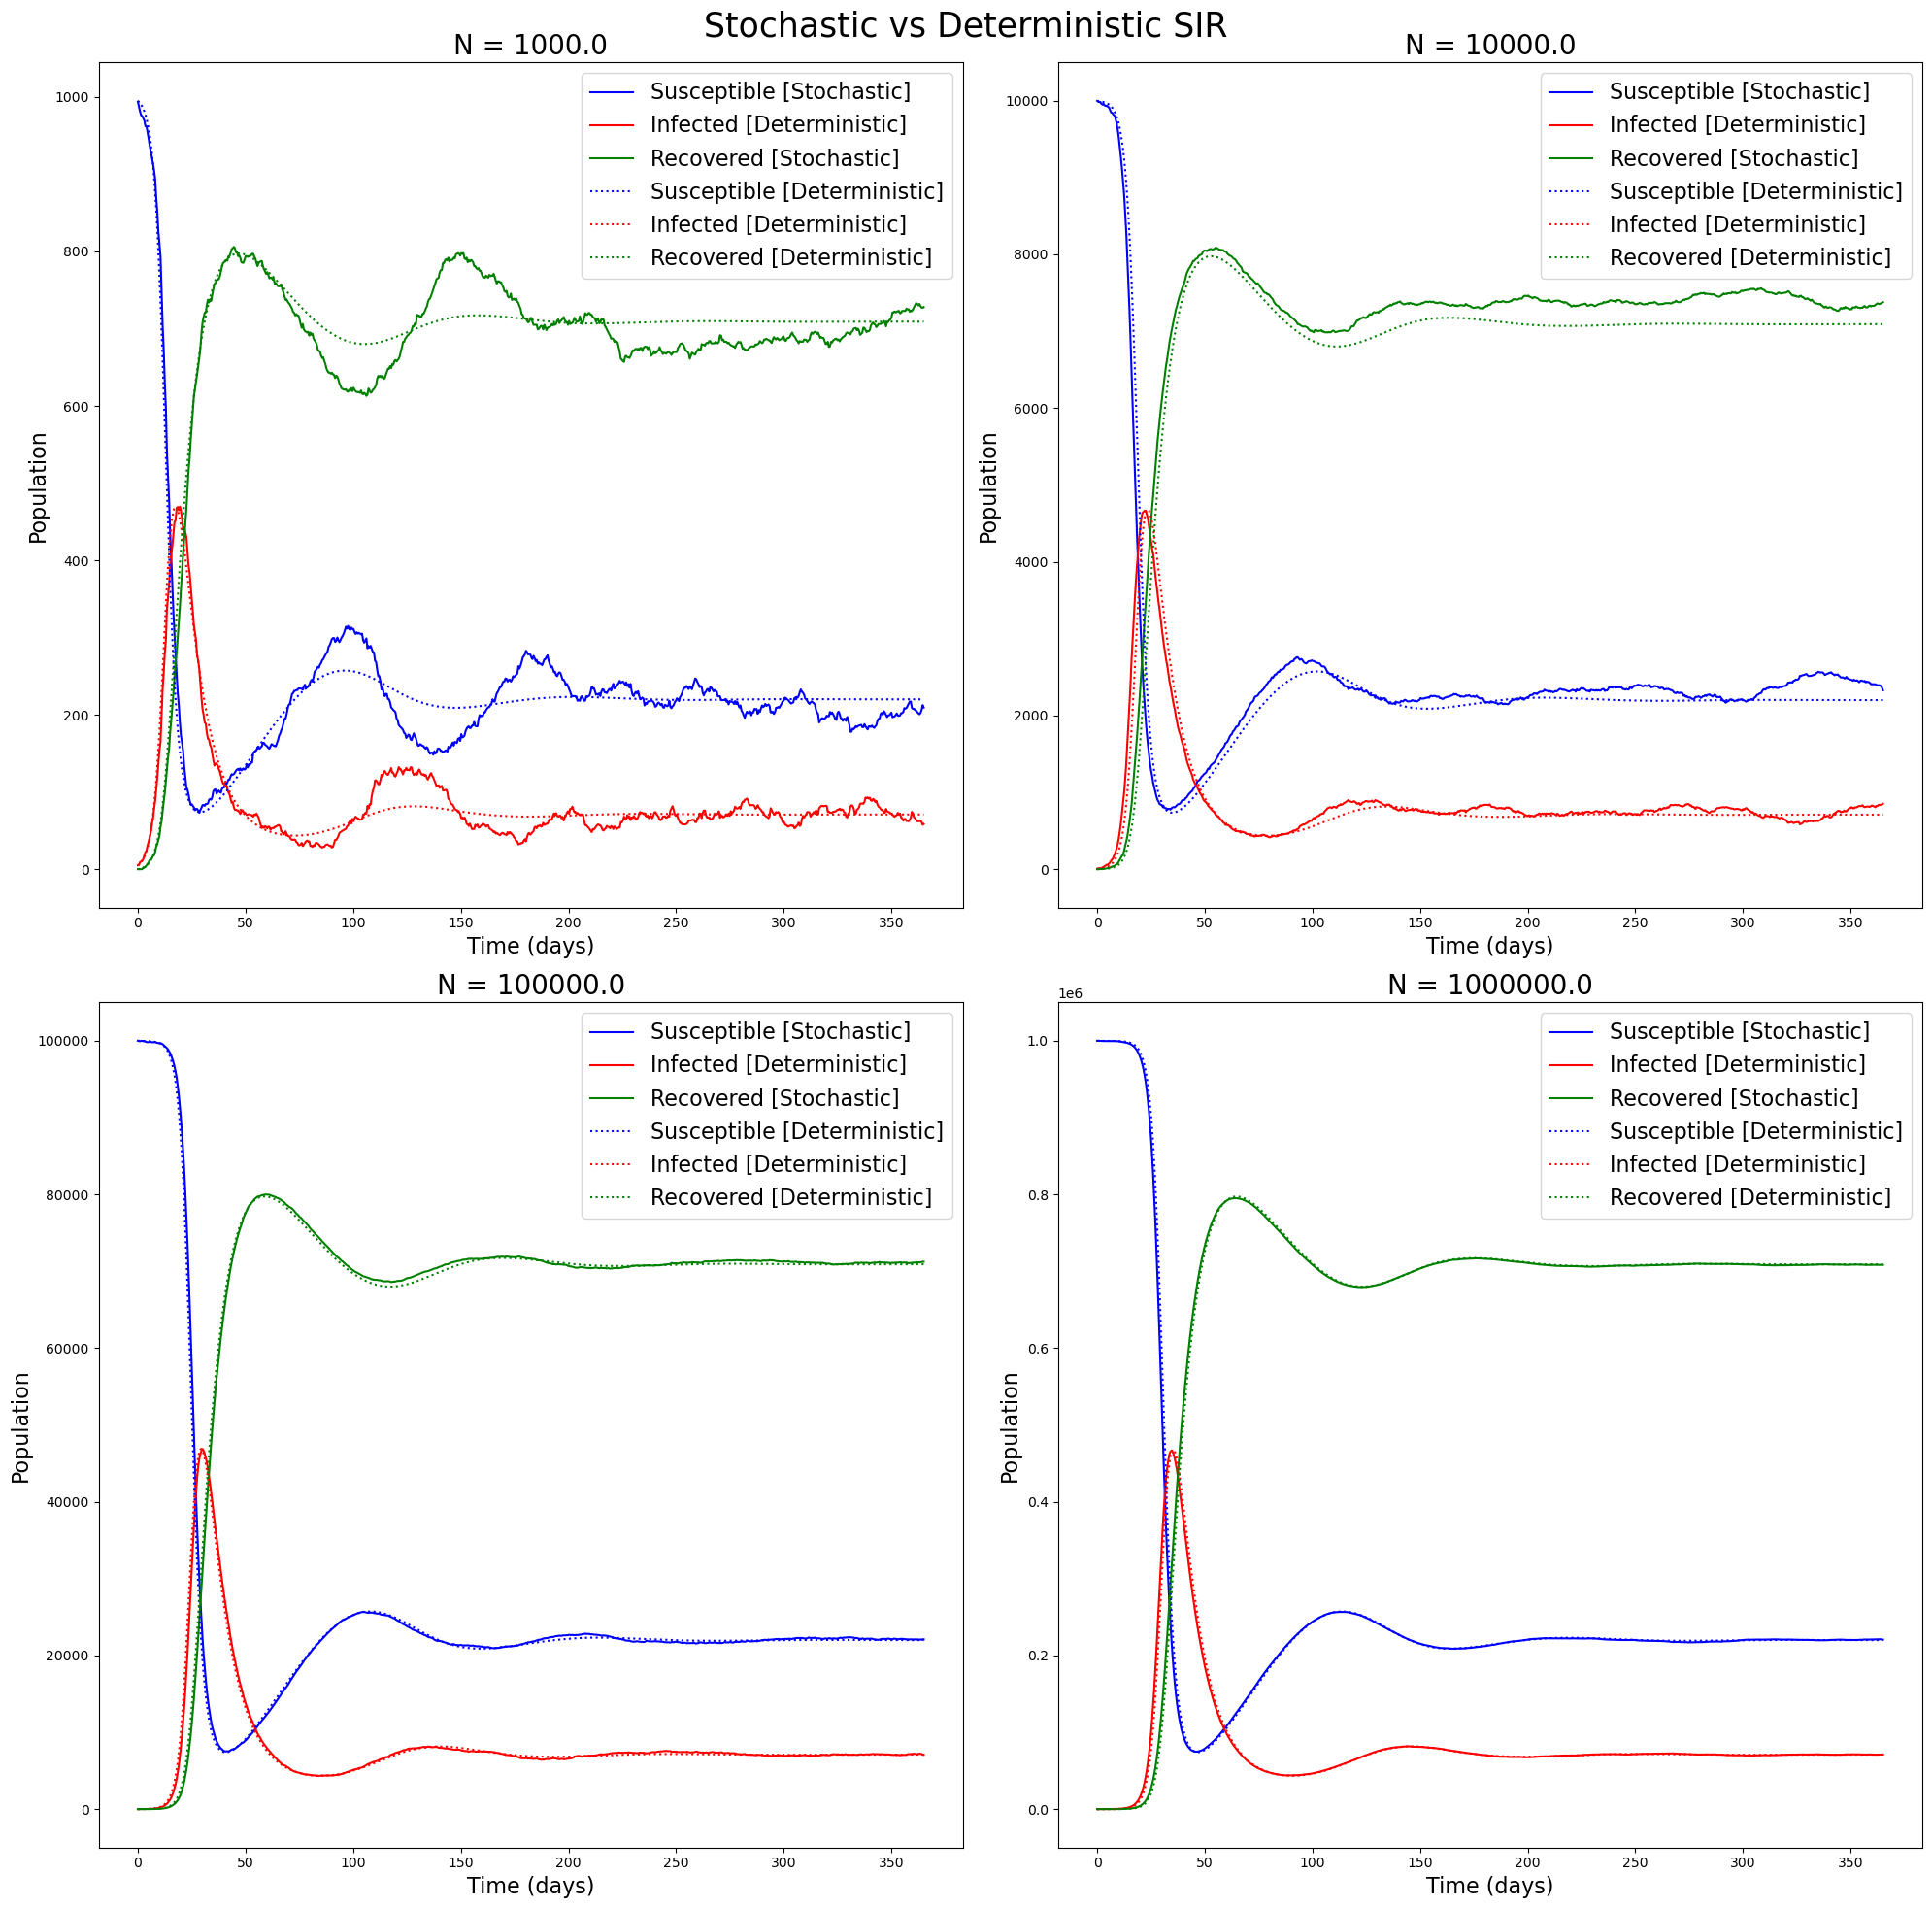

In [ ]:
def deterministic_sir(t, xyz, beta, gamma, mu):
    x, y, z = xyz
    n = x + y + z
    dxdt = mu * n - beta * (x/n) * y - mu * x
    dydt = beta * (x/n) * y - gamma * y - mu * y
    dzdt = gamma * y - mu * z
    return [dxdt, dydt, dzdt]

ns = [1e3, 1e4, 1e5, 1e6]
fig, ax = plt.subplots(2, 2, figsize=(20, 20))
for i, n in enumerate(ns):
    params = Gillespie_Parameters(population_size=n, initial_infected=initial_infected, beta=0.5, gamma=0.1, mu=0.01)
    experiment = Experiment(params, events, sim_length, data_rate=data_rate)
    res = experiment.run().mean_result()
    sol = experiment.integrate_deterministic_sir(deterministic_sir)

    ax[int(i/2), i%2].plot(res.t, res.X, 'b', label='Susceptible [Stochastic]')
    ax[int(i/2), i%2].plot(res.t, res.Y, 'r', label='Infected [Deterministic]')
    ax[int(i/2), i%2].plot(res.t, res.Z, 'g', label='Recovered [Stochastic]')
    ax[int(i/2), i%2].plot(sol.t, sol.y[0], 'b:', label='Susceptible [Deterministic]')
    ax[int(i/2), i%2].plot(sol.t, sol.y[1], 'r:', label='Infected [Deterministic]')
    ax[int(i/2), i%2].plot(sol.t, sol.y[2], 'g:', label='Recovered [Deterministic]')
    ax[int(i/2), i%2].legend(fontsize=16)
    ax[int(i/2), i%2].set_title(f'N = {n}', fontsize=20)
    ax[int(i/2), i%2].set_xlabel('Time (days)', fontsize=16)
    ax[int(i/2), i%2].set_ylabel('Population', fontsize=16)

plt.suptitle('Stochastic vs Deterministic SIR', fontsize=25)
plt.tight_layout()
plt.savefig('./plots/event_based/stochastic-vs-deterministic-sir.png')
plt.show()

## Vary Gillespie parameters

### Vary $R_0$ 

In [7]:
r0s = np.arange(0.5, 10.5, 0.5)
max_iterations = 100

r0experiments = Experiments([])
for r0 in r0s:
    r0experiments.experiments.append(Experiment(Gillespie_Parameters(population_size, initial_infected, beta=r0 * (gamma + mu), gamma=gamma, mu=mu), events=events, simulation_length=sim_length, data_rate=data_rate, max_iterations=max_iterations))
r0experiments.run()

Running experiment: r0 = 0.50, beta = 0.06, gamma = 0.10, mu = 0.01, epsilon = 0.00000, N = 5000.0
Extinction at t=35.47
Ran iteration 1 in 0.28 seconds, rse=0.000
Extinction at t=22.57
Ran iteration 2 in 0.25 seconds, rse=0.356
Extinction at t=48.79
Ran iteration 3 in 0.28 seconds, rse=0.404
Extinction at t=24.28
Ran iteration 4 in 0.28 seconds, rse=0.447
Extinction at t=20.55
Ran iteration 5 in 0.28 seconds, rse=0.465
Extinction at t=17.15
Ran iteration 6 in 0.28 seconds, rse=0.486
Extinction at t=55.92
Ran iteration 7 in 0.28 seconds, rse=0.456
Extinction at t=22.63
Ran iteration 8 in 0.25 seconds, rse=0.457
Extinction at t=57.10
Ran iteration 9 in 0.29 seconds, rse=0.384
Extinction at t=22.64
Ran iteration 10 in 0.27 seconds, rse=0.388
Extinction at t=13.17
Ran iteration 11 in 0.27 seconds, rse=0.398
Extinction at t=9.72
Ran iteration 12 in 0.28 seconds, rse=0.408
Extinction at t=36.04
Ran iteration 13 in 0.29 seconds, rse=0.393
Extinction at t=34.45
Ran iteration 14 in 0.28 second

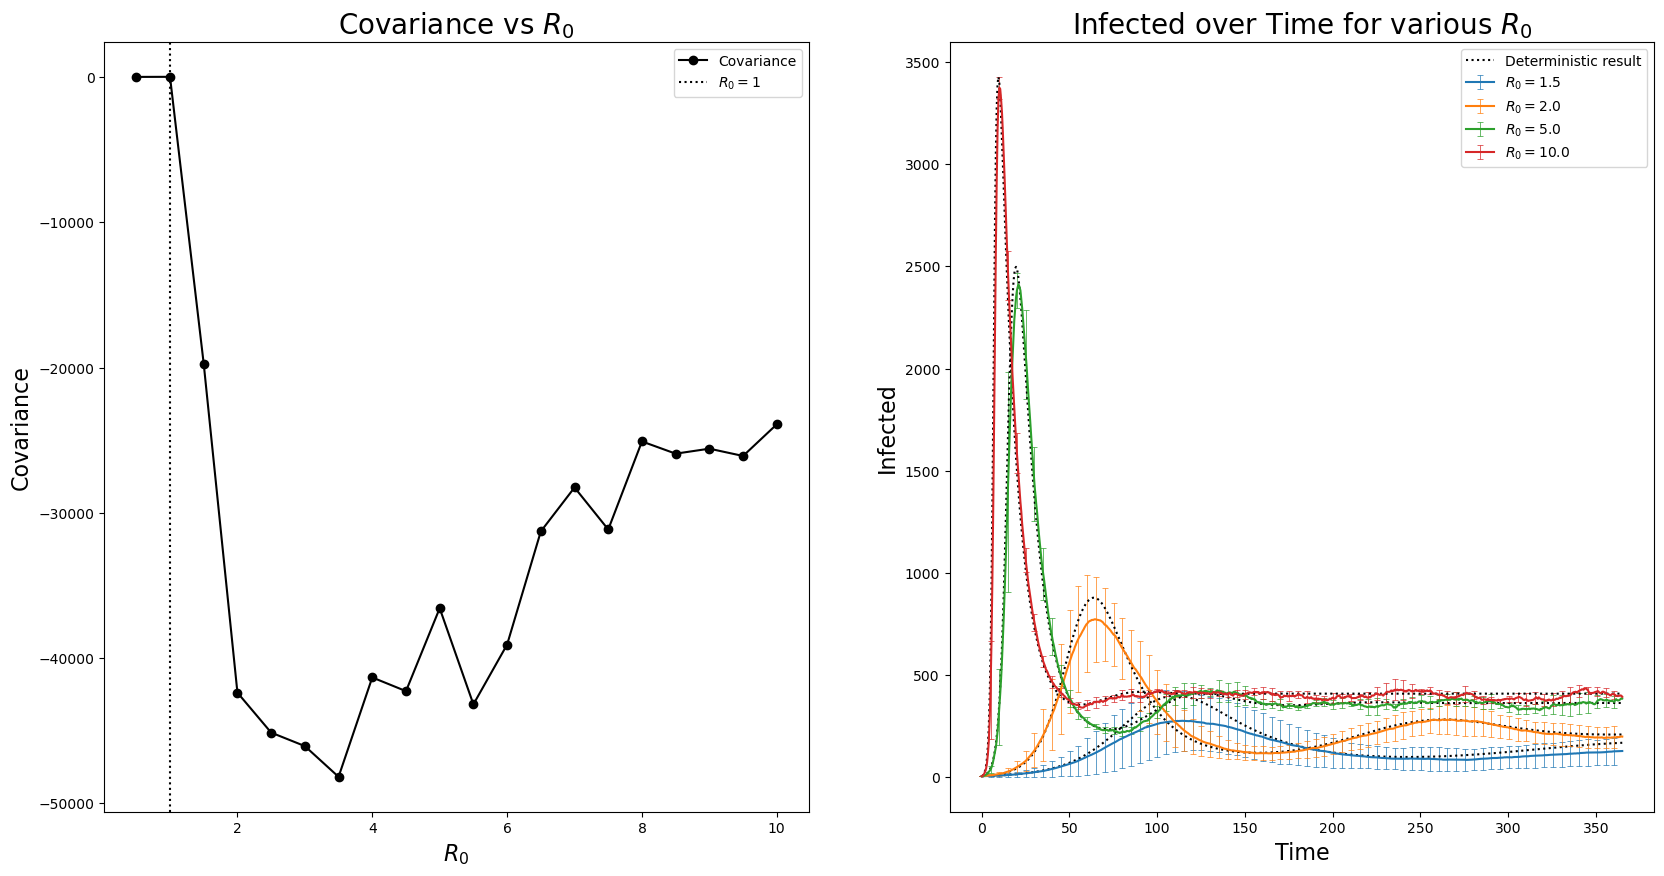

In [55]:
# plot covariance

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.title('Covariance vs $R_0$', fontsize=20)
plt.xlabel('$R_0$', fontsize=16)
plt.ylabel('Covariance', fontsize=16)
# plt.yscale('symlog')

covs = []
for ex in r0experiments.experiments:
    mean = ex.results.mean_result()
    covs.append(mean.s_i_covariance())
plt.plot(r0s, covs, 'ko-', label='Covariance')
plt.axvline(1, color='k', linestyle=':', label='$R_0=1$')
plt.legend()

graphed_r0s = [1.5, 2.0, 5.0, 10.0]
plt.subplot(1, 2, 2)
labeled = False
for ex in r0experiments.experiments:
    if ex.params.r0 not in graphed_r0s:
        continue
    mean, err = ex.results.mean_and_std_infected()
    plt.errorbar(ex.results.t, mean, yerr=err, errorevery=10, capsize=2, elinewidth=0.5, capthick=0.5, label=f"$R_0={ex.params.r0}$")
    det = ex.integrate_deterministic_sir(deterministic_sir)
    detlabel = '_'
    if not labeled:
        labeled = True
        detlabel = 'Deterministic result'
    plt.plot(det.t, det.y[1], 'k:', label=detlabel)
plt.xlabel("Time", fontsize=16)
plt.ylabel("Infected", fontsize=16)
plt.title(f'Infected over Time for various $R_0$' , fontsize=20)
plt.legend()
plt.savefig('./plots/event_based/r0.png')
plt.show()

### Varying $\gamma$

In [16]:
gammas = np.arange(0.025, 0.525, 0.025)
r0 = 5.0

gamma_experiments = Experiments([])
for g in gammas:
    gamma_experiments.experiments.append(Experiment(Gillespie_Parameters(population_size, initial_infected, beta=beta, gamma=g, mu=mu), events=events, simulation_length=sim_length, data_rate=data_rate, max_iterations=max_iterations))
gamma_experiments.run()

Running experiment: r0 = 14.29, beta = 0.50, gamma = 0.03, mu = 0.01, epsilon = 0.00000, N = 5000.0
Ran iteration 1 in 0.68 seconds, rse=0.000
Ran iteration 2 in 0.69 seconds, rse=0.017
Ran iteration 3 in 0.70 seconds, rse=0.016
Ran iteration 4 in 0.69 seconds, rse=0.017
Ran iteration 5 in 0.69 seconds, rse=0.017
Running experiment: r0 = 8.33, beta = 0.50, gamma = 0.05, mu = 0.01, epsilon = 0.00000, N = 5000.0
Ran iteration 1 in 0.68 seconds, rse=0.000
Ran iteration 2 in 0.71 seconds, rse=0.037
Ran iteration 3 in 0.69 seconds, rse=0.031
Ran iteration 4 in 0.68 seconds, rse=0.029
Ran iteration 5 in 0.62 seconds, rse=0.031
Running experiment: r0 = 5.88, beta = 0.50, gamma = 0.08, mu = 0.01, epsilon = 0.00000, N = 5000.0
Ran iteration 1 in 0.65 seconds, rse=0.000
Ran iteration 2 in 0.70 seconds, rse=0.053
Ran iteration 3 in 0.67 seconds, rse=0.049
Ran iteration 4 in 0.64 seconds, rse=0.041
Ran iteration 5 in 0.65 seconds, rse=0.037
Running experiment: r0 = 4.55, beta = 0.50, gamma = 0.10,

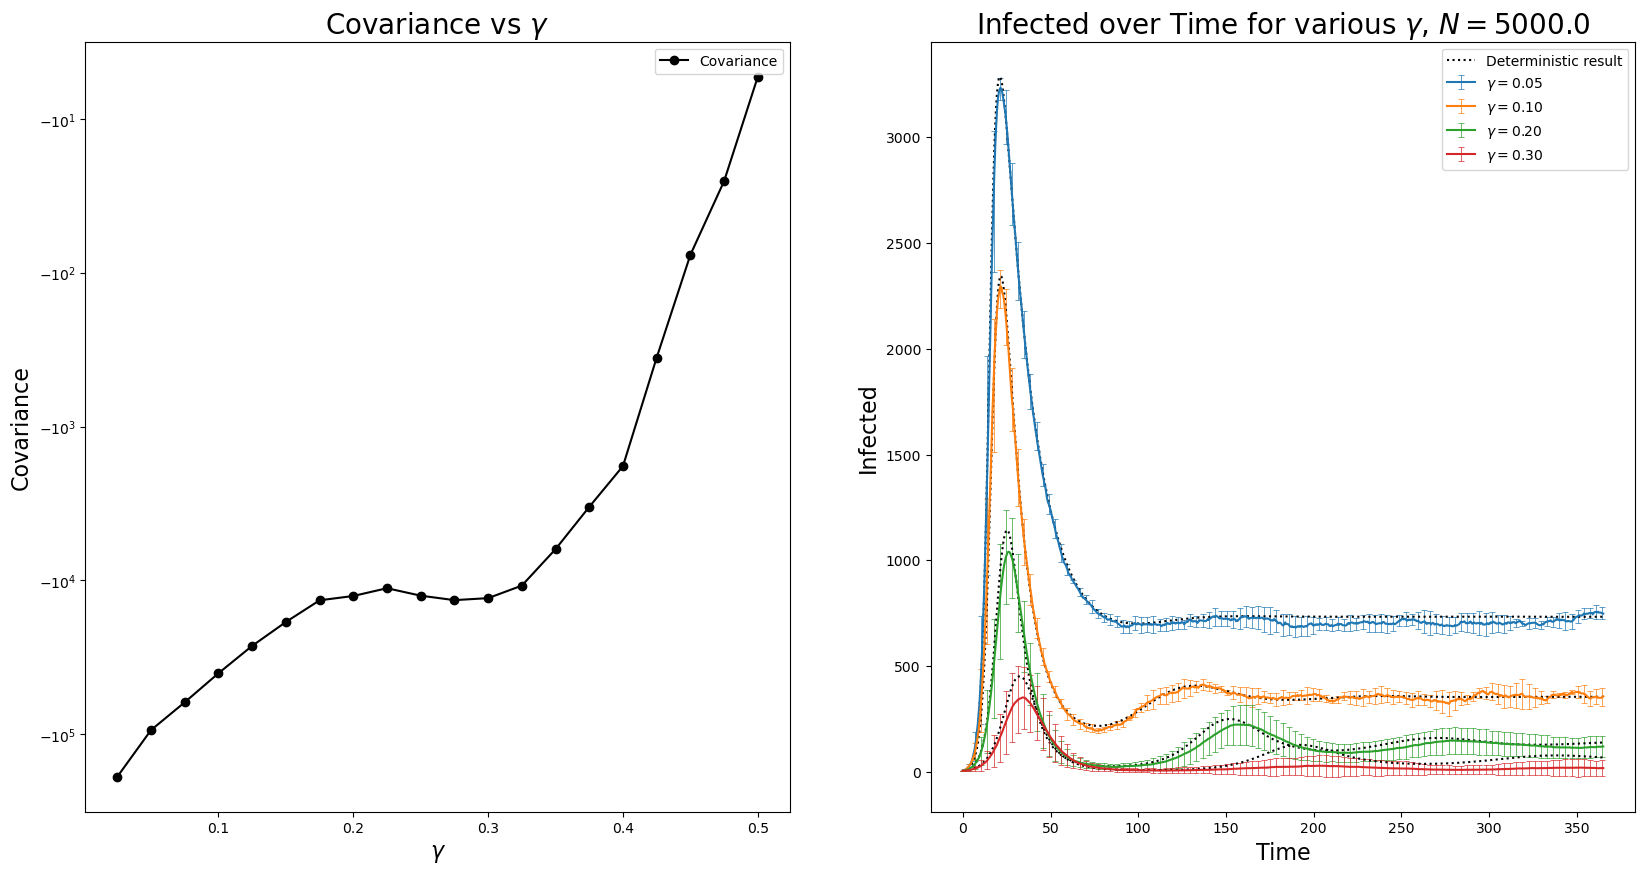

In [56]:
# plot covariance

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.title('Covariance vs $\gamma$', fontsize=20)
plt.xlabel('$\gamma$', fontsize=16)
plt.ylabel('Covariance', fontsize=16)
plt.yscale('symlog')

covs = []
for ex in gamma_experiments.experiments:
    mean = ex.results.mean_result()
    covs.append(mean.s_i_covariance())
plt.plot(gammas, covs, 'ko-', label='Covariance')
plt.legend()

plt.subplot(1, 2, 2)
graphed_gammas = [0.05, 0.1, 0.2, 0.3]
labeled = False
for ex in gamma_experiments.experiments:
    if np.round(ex.params.gamma, 2) not in graphed_gammas:
        continue
    mean, err = ex.results.mean_and_std_infected()
    errbar = plt.errorbar(ex.results.t, mean, yerr=err, errorevery=7, capsize=2, elinewidth=0.5, capthick=0.5, label=f"$\gamma={ex.params.gamma:.2f}$")
    det = ex.integrate_deterministic_sir(deterministic_sir)
    detlabel = '_'
    if not labeled:
        labeled = True
        detlabel = 'Deterministic result'
    plt.plot(det.t, det.y[1], 'k:', label=detlabel)
plt.xlabel("Time", fontsize=16)
plt.ylabel("Infected", fontsize=16)
plt.title(f'Infected over Time for various $\\gamma$, $N={population_size}$', fontsize=20)
plt.legend()
plt.savefig('./plots/event_based/gamma.png')
plt.show()

### Varying N

In [23]:
ns = [5e2, 1e3, 5e3, 1e4, 5e4, 1e5, 5e5]
iterations = 20
r0 = 5.0

n_experiments = Experiments([])
for n in ns:
    n_experiments.experiments.append(Experiment(Gillespie_Parameters(n, initial_infected, beta=beta, gamma=gamma, mu=mu), events=events, simulation_length=sim_length, data_rate=data_rate, max_iterations=max_iterations))
n_experiments.run()

Running experiment: r0 = 4.55, beta = 0.50, gamma = 0.10, mu = 0.01, epsilon = 0.00000, N = 500.0
Ran iteration 1 in 0.08 seconds, rse=0.000
Ran iteration 2 in 0.07 seconds, rse=0.178
Ran iteration 3 in 0.07 seconds, rse=0.162
Ran iteration 4 in 0.08 seconds, rse=0.149
Ran iteration 5 in 0.06 seconds, rse=0.149
Ran iteration 6 in 0.06 seconds, rse=0.137
Ran iteration 7 in 0.06 seconds, rse=0.127
Ran iteration 8 in 0.07 seconds, rse=0.119
Ran iteration 9 in 0.07 seconds, rse=0.113
Ran iteration 10 in 0.06 seconds, rse=0.112
Ran iteration 11 in 0.07 seconds, rse=0.104
Ran iteration 12 in 0.07 seconds, rse=0.099
Ran iteration 13 in 0.08 seconds, rse=0.096
Ran iteration 14 in 0.07 seconds, rse=0.090
Ran iteration 15 in 0.07 seconds, rse=0.087
Ran iteration 16 in 0.06 seconds, rse=0.084
Ran iteration 17 in 0.07 seconds, rse=0.081
Ran iteration 18 in 0.07 seconds, rse=0.078
Ran iteration 19 in 0.07 seconds, rse=0.076
Ran iteration 20 in 0.07 seconds, rse=0.073
Ran iteration 21 in 0.06 second

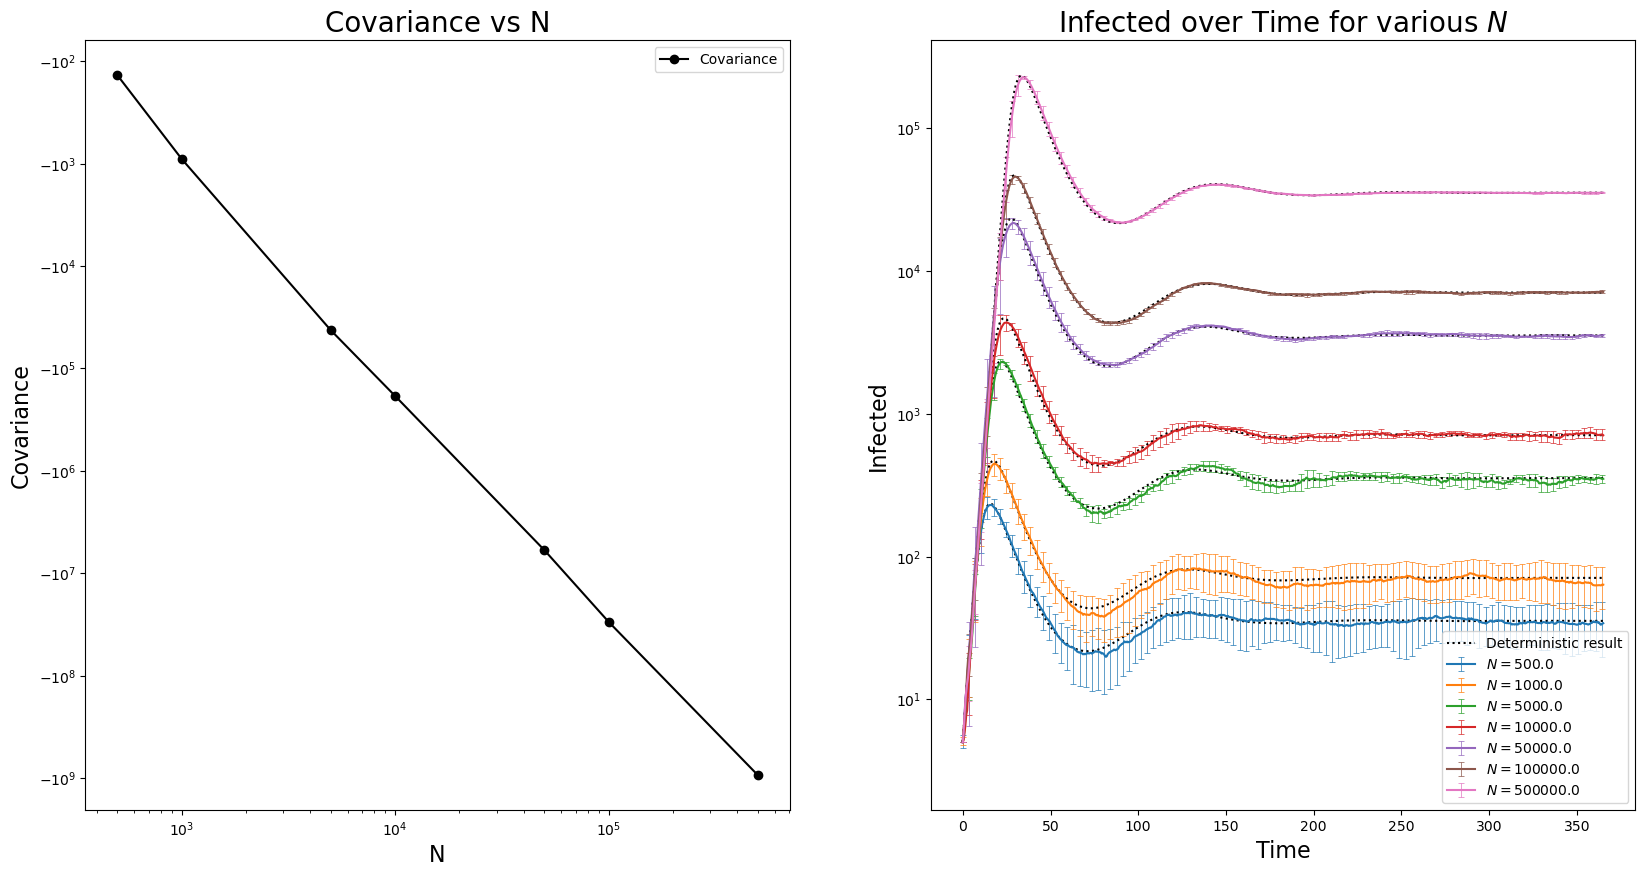

In [ ]:
# plot covariance

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.title('Covariance vs N', fontsize=20)
plt.xlabel('N', fontsize=16)
plt.ylabel('Covariance', fontsize=16)
plt.yscale('symlog')
plt.xscale('log')

covs = []
for ex in n_experiments.experiments:
    mean = ex.results.mean_result()
    covs.append(mean.s_i_covariance())
plt.plot(ns, covs, 'ko-', label='Covariance')
plt.legend()

plt.subplot(1, 2, 2)
plt.yscale('symlog')
labeled = False
for ex in n_experiments.experiments:
    mean, err = ex.results.mean_and_std_infected()
    plt.errorbar(ex.results.t, mean, yerr=err, errorevery=7, capsize=2, elinewidth=0.5, capthick=0.5, label=f"$N={ex.params.population.N()}$")
    det = ex.integrate_deterministic_sir(deterministic_sir)
    detlabel = '_'
    if not labeled:
        labeled = True
        detlabel = 'Deterministic result'
    plt.plot(det.t, det.y[1], 'k:', label=detlabel)
plt.xlabel("Time", fontsize=16)
plt.ylabel("Infected", fontsize=16)
plt.title(f'Infected over Time for various $N$', fontsize=20)
plt.legend()
plt.savefig('./plots/event_based/n.png')
plt.show()

## Extinctions

### N

In [46]:
ns = np.linspace(1e2, 1e3, 10)
r0_ext = 5
gamma_ext = 0.2
mu_ext = 0.01
epsilon_base = 0.2/365

max_iterations_ext = 100

sim_years_ext = 1
data_rate_ext = 1

events_with_imports = copy.copy(events)
events_with_imports.append(ImportEvent)
experiment_list = []


for n in ns:
    experiment_list.append(Experiment(Gillespie_Parameters(n, initial_infected, r0_ext * (gamma_ext + mu_ext), gamma_ext, mu_ext, epsilon=epsilon_base * np.sqrt(n)), events=events_with_imports, simulation_length=sim_length * sim_years_ext, data_rate=data_rate_ext, max_iterations=max_iterations_ext))
experiments_ext_n = Experiments(experiment_list)
experiments_ext_n.run()


Running experiment: r0 = 5.00, beta = 1.05, gamma = 0.20, mu = 0.01, epsilon = 0.00548, N = 100.0
Extinction at t=28.88
Import at t=300.27
Extinction at t=335.15
Import at t=355.26
Extinction at t=358.51
Ran iteration 1 in 0.03 seconds, rse=0.000
Extinction at t=31.21
Import at t=46.90
Extinction at t=61.55
Import at t=219.85
Extinction at t=253.40
Ran iteration 2 in 0.01 seconds, rse=0.585
Extinction at t=29.69
Import at t=75.14
Extinction at t=127.41
Import at t=249.13
Extinction at t=285.56
Ran iteration 3 in 0.02 seconds, rse=0.719
Extinction at t=47.24
Ran iteration 4 in 0.01 seconds, rse=0.763
Extinction at t=82.59
Ran iteration 5 in 0.01 seconds, rse=0.747
Extinction at t=34.85
Import at t=247.50
Extinction at t=282.90
Import at t=350.05
Ran iteration 6 in 0.01 seconds, rse=0.730
Extinction at t=29.31
Ran iteration 7 in 0.01 seconds, rse=0.742
Extinction at t=53.00
Import at t=264.03
Extinction at t=292.06
Ran iteration 8 in 0.01 seconds, rse=0.741
Extinction at t=21.20
Import a

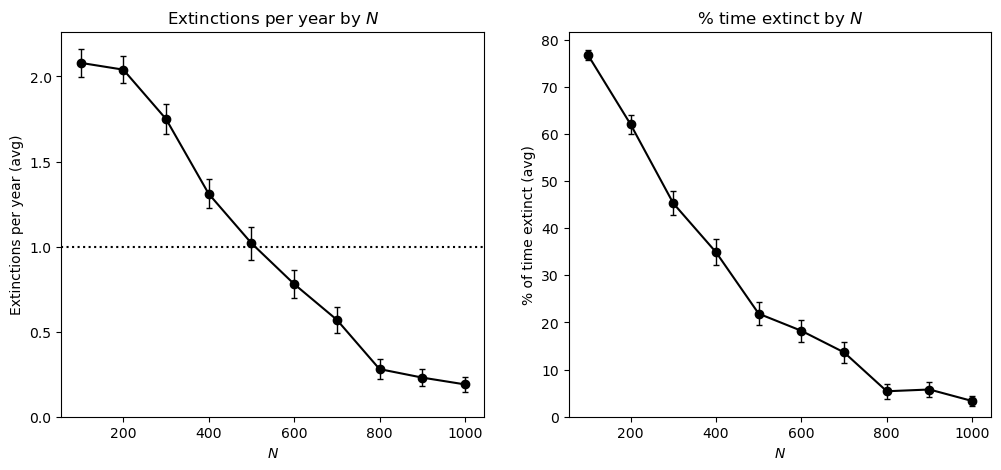

In [ ]:
extinctions_n = np.zeros(len(ns))
extinct_time_n = np.zeros(len(ns))
extinct_time_stderr_n = np.zeros(len(ns))
extinction_stderr_n = np.zeros(len(ns))

for i, n in enumerate(ns):
    ex = experiments_ext_n.experiments[i]
    extinctions_n[i] = np.mean(ex.extinction_counts/sim_years_ext)
    extinction_stderr_n[i] = (np.std(ex.extinction_counts)/np.sqrt(sim_years_ext)) / np.sqrt(len(ex.extinction_counts) * sim_years_ext)
    extinct_time_n[i] = np.average((len(ex.results.t) - np.count_nonzero(ex.results.Ys, axis=1))/len(ex.results.t)) * 100
    extinct_time_stderr_n[i] = (np.std((len(ex.results.t) - np.count_nonzero(ex.results.Ys, axis=1))/len(ex.results.t)) * 100 / np.sqrt(sim_years_ext)) / np.sqrt(len(ex.extinction_counts) * sim_years_ext)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Extinctions per year by $N$')
plt.xlabel('$N$')
plt.ylabel('Extinctions per year (avg)')
# plt.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
plt.errorbar(ns, extinctions_n, yerr=extinction_stderr_n, fmt='ko-', capsize=2, capthick=1, elinewidth=1)
plt.axhline(y=1.0, color='k', linestyle=':')
plt.ylim(bottom=0)

plt.subplot(1, 2, 2)
plt.title('% time extinct by $N$')
plt.xlabel('$N$')
plt.ylabel('% of time extinct (avg)')
# plt.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
plt.errorbar(ns, extinct_time_n, yerr=extinct_time_stderr_n, fmt='ko-', capsize=2, capthick=1, elinewidth=1)
plt.ylim(bottom=0)
plt.savefig('./plots/event_based/extinction_by_n.png')
plt.show()

### $R_0$

In [28]:
r0s = np.linspace(1, 10, 10)
n_ext = 5e2

experiment_list = []

for r in r0s:
    experiment_list.append(Experiment(Gillespie_Parameters(n_ext, initial_infected, r * (gamma_ext + mu_ext), gamma_ext, mu_ext, epsilon=epsilon_base * np.sqrt(n_ext)), events=events_with_imports, simulation_length=sim_length * sim_years_ext, data_rate=data_rate_ext, max_iterations=max_iterations_ext))
experiments_ext_r0 = Experiments(experiment_list)
experiments_ext_r0.run()

Running experiment: r0 = 1.00, beta = 0.21, gamma = 0.20, mu = 0.01, epsilon = 0.01225, N = 500.0
Extinction at t=14.05
Import at t=192.85
Extinction at t=195.24
Ran iteration 1 in 0.03 seconds, rse=0.000
Extinction at t=14.45
Import at t=332.71
Ran iteration 2 in 0.03 seconds, rse=0.590
Extinction at t=90.80
Import at t=92.22
Extinction at t=93.31
Ran iteration 3 in 0.03 seconds, rse=0.749
Extinction at t=79.53
Import at t=103.38
Extinction at t=123.22
Import at t=151.85
Extinction at t=152.87
Ran iteration 4 in 0.03 seconds, rse=0.694
Extinction at t=48.07
Import at t=62.96
Extinction at t=69.84
Import at t=217.97
Extinction at t=222.14
Import at t=233.07
Extinction at t=246.98
Import at t=286.96
Ran iteration 5 in 0.03 seconds, rse=0.701
Extinction at t=137.15
Import at t=210.97
Extinction at t=298.75
Ran iteration 6 in 0.04 seconds, rse=0.690
Extinction at t=71.11
Import at t=145.90
Extinction at t=146.76
Import at t=307.94
Extinction at t=327.24
Ran iteration 7 in 0.04 seconds, rs

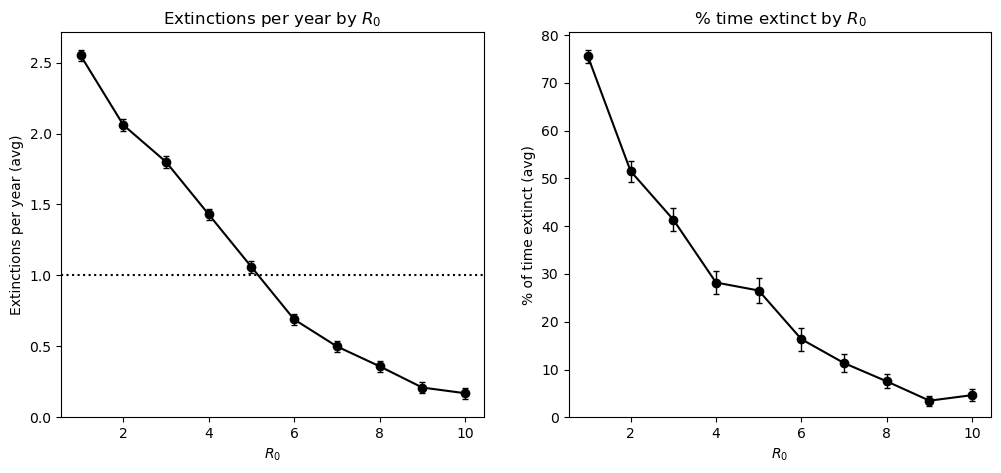

In [ ]:
extinctions_r0 = np.zeros(len(r0s))
extinct_time_r0 = np.zeros(len(r0s))
extinction_stderr_r0 = np.zeros(len(r0s))
extinct_time_stderr_r0 = np.zeros(len(r0s))

for i, n in enumerate(r0s):
    ex = experiments_ext_r0.experiments[i]
    extinctions_r0[i] = np.mean(ex.extinction_counts/sim_years_ext)
    extinction_stderr_r0 = (np.std(ex.extinction_counts)/np.sqrt(sim_years_ext)) / np.sqrt(len(ex.extinction_counts) * sim_years_ext)
    extinct_time_r0[i] = np.average((len(ex.results.t) - np.count_nonzero(ex.results.Ys, axis=1))/len(ex.results.t)) * 100
    extinct_time_stderr_r0[i] = (np.std((len(ex.results.t) - np.count_nonzero(ex.results.Ys, axis=1))/len(ex.results.t)) * 100 / np.sqrt(sim_years_ext)) / np.sqrt(len(ex.extinction_counts) * sim_years_ext)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Extinctions per year by $R_0$')
plt.xlabel('$R_0$')
plt.ylabel('Extinctions per year (avg)')
plt.errorbar(r0s, extinctions_r0, yerr=extinction_stderr_r0, fmt='ko-', capsize=2, capthick=1, elinewidth=1)
plt.axhline(y=1.0, color='k', linestyle=':')
plt.ylim(bottom=0)

plt.subplot(1, 2, 2)
plt.title('% time extinct by $R_0$')
plt.xlabel('$R_0$')
plt.ylabel('% of time extinct (avg)')
plt.errorbar(r0s, extinct_time_r0, yerr=extinct_time_stderr_r0, fmt='ko-', capsize=2, capthick=1, elinewidth=1)
plt.ylim(bottom=0)
plt.savefig('./plots/event_based/extinction_by_r0.png')
plt.show()

## Plotting CV

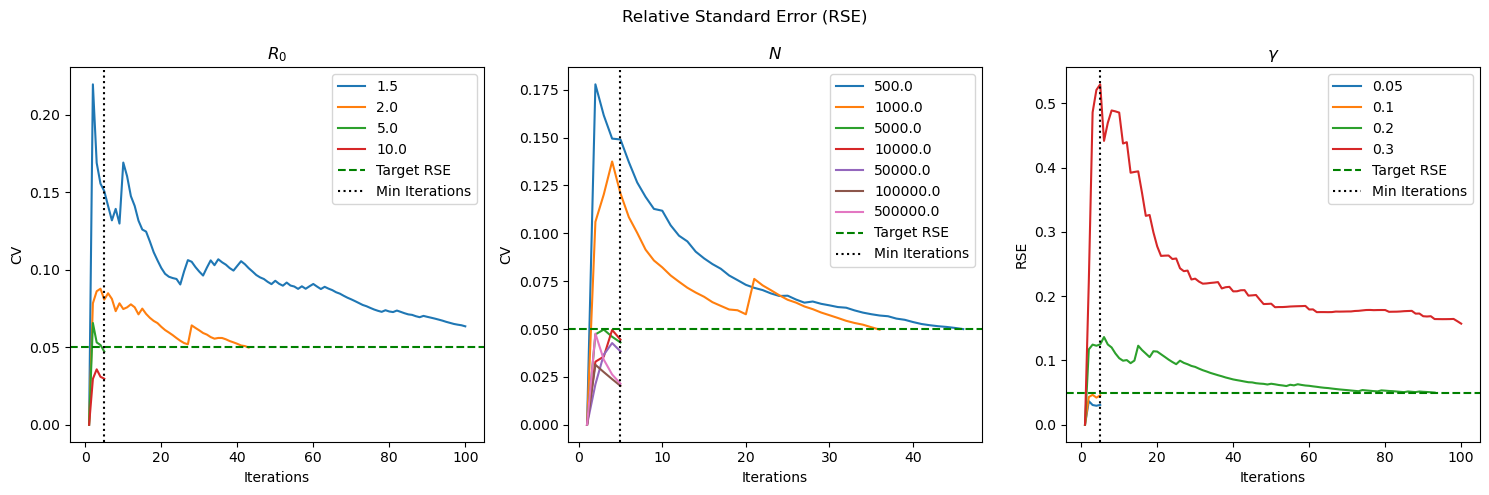

In [ ]:
def plot_rse(ax: plt.Axes, label: str, rse: np.ndarray, max_iter: int, threshold: float):
    ax.plot(np.arange(max_iter)+1, rse, label=label)

# graphed_r0s = [2.0, 3.0, 4.0, 5.0]
n_exp = n_experiments.experiments[0]
gamma_exp = gamma_experiments.experiments[0]

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i, r0exp in enumerate(r0experiments.experiments):
    if r0exp.params.r0 not in graphed_r0s:
        continue
    plot_rse(ax[0], str(r0exp.params.r0), r0exp.rses, r0exp.max_iterations, r0exp.target_rse)
ax[0].set_title('$R_0$')
ax[0].set_ylabel('CV')
ax[0].set_xlabel('Iterations')
ax[0].axhline(r0exp.target_rse, color='g', linestyle='--', label='Target RSE')
ax[0].axvline(r0exp.min_iterations, color='k', linestyle=':', label='Min Iterations')
ax[0].legend()
for i, n_exp in enumerate(n_experiments.experiments):
    plot_rse(ax[1], str(n_exp.params.population.N()), n_exp.rses, n_exp.max_iterations, n_exp.target_rse)
ax[1].set_title('$N$')
ax[1].set_ylabel('CV')
ax[1].set_xlabel('Iterations')
ax[1].axhline(r0exp.target_rse, color='g', linestyle='--', label='Target RSE')
ax[1].axvline(r0exp.min_iterations, color='k', linestyle=':', label='Min Iterations')
ax[1].legend()
for i, gamma_exp in enumerate(gamma_experiments.experiments):
    if np.round(gamma_exp.params.gamma, 2) not in graphed_gammas:
        continue
    plot_rse(ax[2], str(np.round(gamma_exp.params.gamma, 2)), gamma_exp.rses, gamma_exp.max_iterations, gamma_exp.target_rse)
ax[2].set_title('$\gamma$')
ax[2].set_ylabel('RSE')
ax[2].set_xlabel('Iterations')
ax[2].axhline(r0exp.target_rse, color='g', linestyle='--', label='Target RSE')
ax[2].axvline(r0exp.min_iterations, color='k', linestyle=':', label='Min Iterations')
ax[2].legend()

plt.suptitle('Relative Standard Error (RSE)')

plt.tight_layout()
plt.savefig('./plots/event_based/rse.png')
plt.show()